# Testing YieldFactorModels Filter Functionality

This notebook tests the filter functions in the YieldFactorModels.jl package.

## 1. Setup and Import

In [ ]:
# Add the package to the environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()


: 

## 1.5 Test Performance Improvements

The model has been optimized based on profiling data:
- ✅ Pre-allocated buffers for network outputs
- ✅ Pre-computed maturity transformations  
- ✅ In-place operations in `update_factor_loadings!`
- ✅ Reduced allocations in hot loops

Expected improvements: 15-30% faster, 50% fewer allocations

In [2]:
# Import the package and required dependencies
using Revise
using YieldFactorModels
using LinearAlgebra
using ForwardDiff
using Random

# NOTE: `export VAR=...` is a shell command and is not valid Julia syntax in a code cell.
# For runtime settings that can be changed from within Julia use `ENV` or library APIs.
# Set BLAS / native libraries thread knobs where possible:
ENV["OPENBLAS_NUM_THREADS"] = "1"
ENV["OMP_NUM_THREADS"] = "1"
ENV["MKL_NUM_THREADS"] = "1"  # If MKL.jl is used, prefer MKL.set_num_threads(1)
# Also set BLAS threads from Julia (affects LinearAlgebra.BLAS):
LinearAlgebra.BLAS.set_num_threads(1)

# Important: `JULIA_NUM_THREADS` controls Julia's worker threads and must be
# set before the Julia process / kernel is started. You cannot change the number
# of Julia threads from inside a running kernel. To run the kernel with 1 thread,
# start Jupyter / the kernel with the env var set (see instructions below).

Random.seed!(123)  # For reproducibility


TaskLocalRNG()

In [3]:
cd("..")

## 3. Test Individual Functions

### 3.1 Test `initialize_filter!`

In [4]:
println(pwd())

/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects


In [5]:
data, maturities = load_data("YieldFactorModels.jl/data/", "6")

([7.83403892981863 8.30247299311406 … 4.3268632601382855 4.155682521352292; 7.96778641185185 8.46780405699119 … 4.3328289043004515 4.159368653729067; … ; 10.9519681799619 11.657231239239 … 4.125693391252582 4.537209692896116; 11.371582727334 12.0250709896095 … 4.324326305225288 4.7829716342137685], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  30.0, 36.0, 48.0, 60.0, 72.0, 84.0, 96.0, 108.0, 120.0, 180.0])

### 3.2 Test `get_β_OLS!`

In [6]:
# Test the OLS estimation function
Z_test = randn(24, 3)
y_test = randn(24)
beta_test = zeros(3)
YieldFactorModels.get_β_OLS!(beta_test, Z_test, y_test)

### 3.4 Test Optimziation


In [7]:
float_type = Float64
model, model_type = YieldFactorModels.create_model("NS", maturities,24, 3, float_type)
param_groups = YieldFactorModels.get_param_groups(model, String[])
all_params = YieldFactorModels.load_initial_parameters!(model, model_type, float_type)
YieldFactorModels.set_params!(model, all_params[:, 1])
# Load static parameters if applicable
all_params[:,1] = YieldFactorModels.load_static_parameters!(model, model_type, "YieldFactorModels.jl/results/", "6", all_params[:,1])
# Convert parameters to appropriate float type
all_params = convert(Matrix{float_type}, all_params)
results = predict(model, data[:, 1:end])


Default param groups assigned.


┌ Warning: Static parameters for NS not found, using default initialization.
└ @ YieldFactorModels ~/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/src/YieldFactorModels.jl:190


(preds = [-15.038586001407154 -15.30157308699271 … 4.4267785226784495 0.1899929808591074; -13.133102938463612 -13.417607600677224 … 3.5625209168600964 0.013780408678833813; … ; -8.016533550177897 -8.2696673107114 … 1.596531444932718 -0.2786852737017665; -7.982507318733289 -8.235346522764985 … 1.5837991179627198 -0.28045605137392926], factors = [-7.91445485584407 -8.166704946872153 … 1.558334464022723 -0.28399760671825486; -8.848427854378208 -8.724255272105937 … 4.109816200551135 0.8674290757963443; -7.953144907628962 -8.222764466763355 … 2.1771897044176955 0.006950737690008535], states = [0.3086746466394844 0.3086746466394844 … 0.3086746466394844 0.3086746466394844], factor_loadings_1 = [0.5441044650540914 0.5441044650540914 … 0.5441044650540914 0.5441044650540914; 0.34107074657856373 0.34107074657856373 … 0.34107074657856373 0.34107074657856373; … ; 0.0060755439850639645 0.0060755439850639645 … 0.0060755439850639645 0.0060755439850639645; 0.00405036265670931 0.00405036265670931 … 0.00

In [8]:
# Alternative: Use BenchmarkTools for detailed timing
using BenchmarkTools

println("Benchmarking with BenchmarkTools...")
println("(This may take a minute...)\n")

benchmark_result = @benchmark YieldFactorModels.get_loss(
    $model, 
    $data, 
) samples=20 evals=3

display(benchmark_result)

println("\n" * "="^60)
println("Summary:")
println("  Minimum time: $(minimum(benchmark_result.times) / 1e9) seconds")
println("  Median time:  $(median(benchmark_result.times) / 1e9) seconds")
println("  Mean time:    $(mean(benchmark_result.times) / 1e9) seconds")
println("  Allocations:  $(benchmark_result.allocs)")
println("  Memory:       $(benchmark_result.memory / 1e6) MB")
println("="^60)

Benchmarking with BenchmarkTools...
(This may take a minute...)



BenchmarkTools.Trial: 20 samples with 3 evaluations per sample.
 Range (min … max):  19.994 ms … 29.766 ms  ┊ GC (min … max):  9.82% … 8.04%
 Time  (median):     20.646 ms              ┊ GC (median):    12.16%
 Time  (mean ± σ):   21.322 ms ±  2.100 ms  ┊ GC (mean ± σ):  11.82% ± 1.80%

  ▁ ▄█     ▁                                                   
  █▆██▆▆▆▆▁█▆▆▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  20 ms           Histogram: frequency by time        29.8 ms <

 Memory estimate: 45.10 MiB, allocs estimate: 206937.


Summary:
  Minimum time: 0.019994166666666667 seconds
  Median time:  0.0206460625 seconds
  Mean time:    0.021321651383333334 seconds
  Allocations:  206937
  Memory:       47.2904 MB
Summary:
  Minimum time: 0.019994166666666667 seconds
  Median time:  0.0206460625 seconds
  Mean time:    0.021321651383333334 seconds
  Allocations:  206937
  Memory:       47.2904 MB


### 3.4 Test Handling Missing Data

In [18]:
# set pwd one level back 

YieldFactorModels.run("6", 231, 12, false, "SD-NS", Float64; window_type = "expanding",  max_group_iters=10, run_optimization=true, reestimate=false )
# vcat(fill("1", 22), fill("2", 12) )

Default param groups assigned.
✓ Found valid initial parameters after 0 perturbations

Starting block-coordinate optimization

--- Starting point 1/1 ---
Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     4.194032e+01     4.741920e+00
 * time: 0.00020885467529296875
    10     3.345361e+01     4.109543e-02
 * time: 0.053810834884643555
    20     3.331169e+01     1.847643e-03
 * time: 0.07740283012390137
    30     3.330570e+01     1.055368e-03
 * time: 0.09402084350585938
    40     3.329310e+01     1.033705e-03
 * time: 0.10852789878845215
    50     3.329294e+01     9.682883e-05
 * time: 0.12586379051208496
    60     3.329185e+01     1.198972e-04
 * time: 0.14020586013793945
    70     3.329154e+01     1.017911e-05
 * time: 0.15271997451782227
Iter     Function value   Gradient norm 
     0     3.329153e+01     3.633339e+01
 * time: 0.00019502639770507812
    10     2.228084e-01     2.617618e-01
 * time: 0.10967707633972168
    20     1.

MSEDλModel{Float64, Float64, Float64}(MSEDrivenBaseModel{Float64, Float64, Float64}([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  30.0, 36.0, 48.0, 60.0, 72.0, 84.0, 96.0, 108.0, 120.0, 180.0], 24, 3, 1, [1.0 0.9133718527371303 0.08147460635454595; 1.0 0.836601690976254 0.14454866243732778; … ; 1.0 0.045278449879033525 0.04527844962296134; 1.0 0.03018563326041859 0.030185633260414492], [4.5078599881068735, -0.35764066603146566, -0.706564957088768], [0.9834988348505416 -0.012512216729670157 0.010070393160144787; -0.009068995256757473 0.925218729332415 0.0804854092985384; 0.020834550251142222 0.13215583938285852 0.8356653349572616], [2.8813578370906647, 1.1280101483148641, 1.370078872694317], [0.04786243606506262, 0.00021369393443057948, 0.0160465299950317], [1], [-1.7484336489613423], [0.37071465326956665], [1.0], [-0.09540183869338432], [-0.0], Function[YieldFactorModels.from_R_to_pos, YieldFactorModels.from_R_to_01, identity, identity, identity, identity, YieldFactorModels.fr

## 4. Test `get_mse` Function

Test the mean squared error calculation over the full dataset.

In [10]:
using CairoMakie
using DelimitedFiles

(480, 24)
(480, 4)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/4JW9B/src/scenes.jl:264


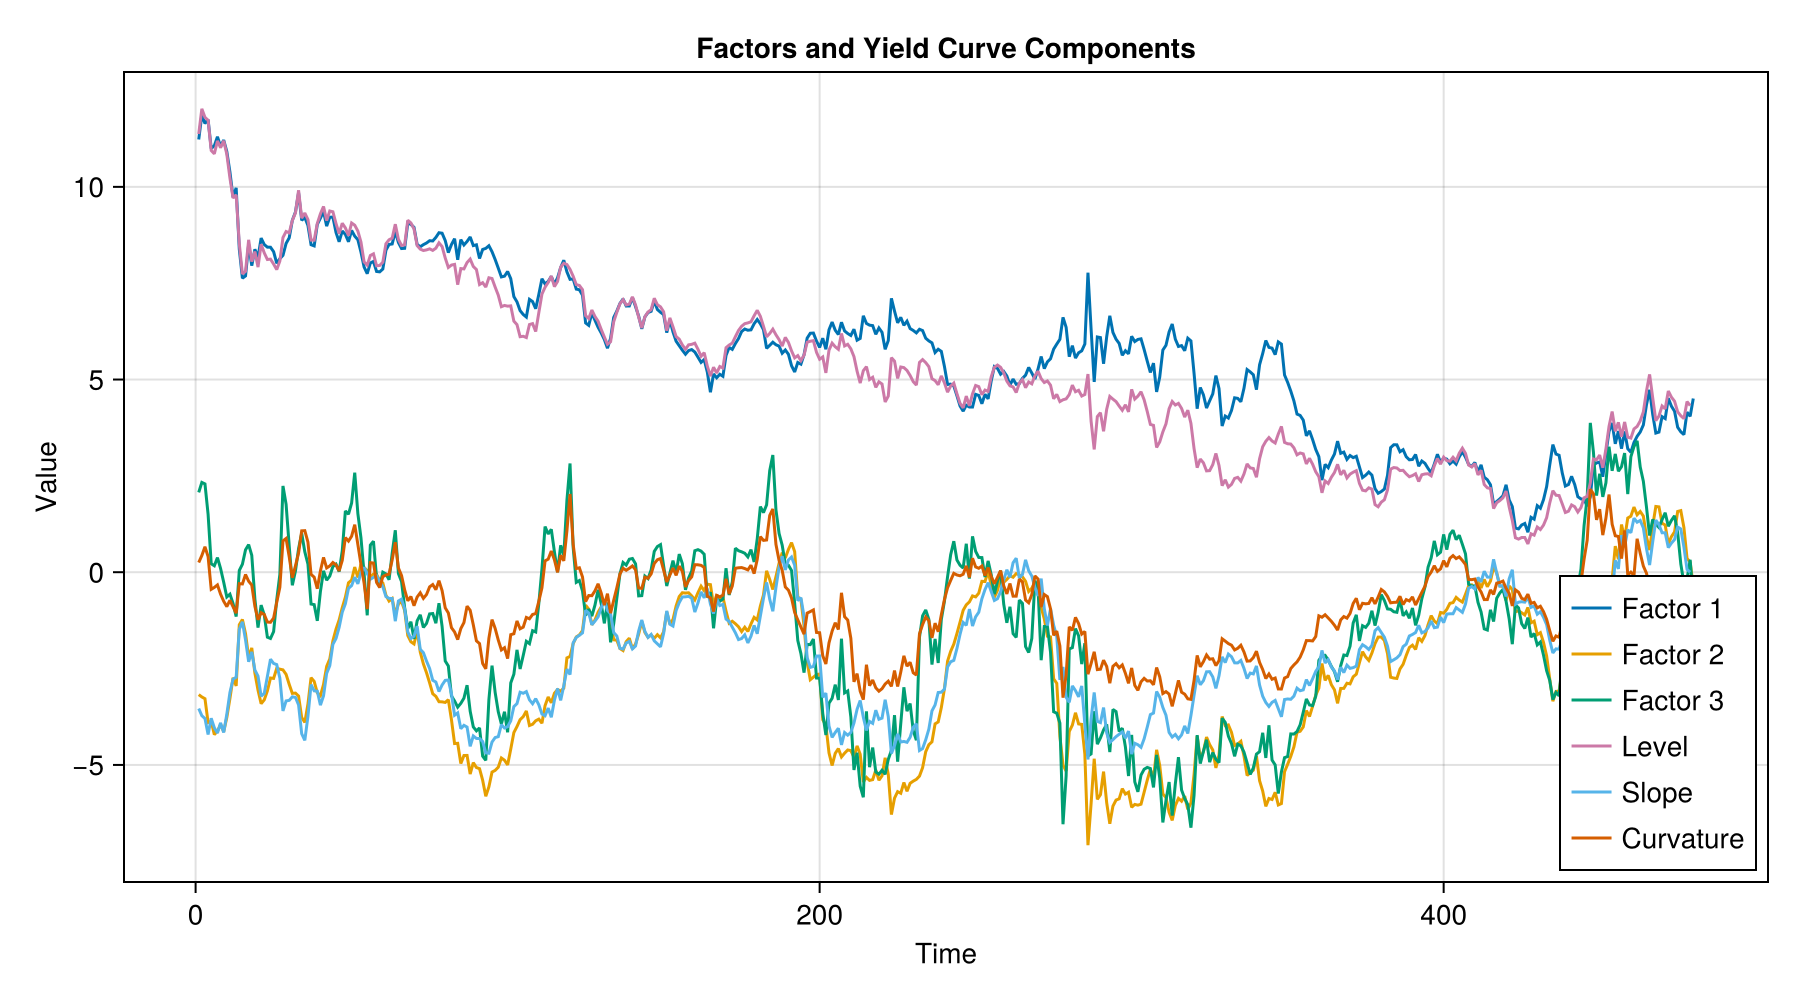

In [22]:
model_name = "SD-NS"
# read /Users/siccokooiker/surfdrive/JuliaProjects/YieldFactorModels.jl/results/SD-NS/SD-NS__thread_id__6__factors_filtered_outofsample.csv
filtered_data = readdlm("/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/$(model_name)/$(model_name)__thread_id__6__factors_filtered_outofsample.csv", ',')
# /Users/siccokooiker/surfdrive/JuliaProjects/YieldFactorModels.jl/data/thread_id__6__data.csv
data = readdlm("/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/data/thread_id__6__data.csv", ',')
data = data'
# print shape
println(size(data))
println(size(filtered_data))

# plot first 3 factors over time using CairoMakie

f = Figure(resolution = (900, 500))
ax = Axis(f[1, 1], xlabel = "Time", ylabel = "Value", title = "Factors and Yield Curve Components")
lines!(ax, filtered_data[:, 1], label = "Factor 1")
lines!(ax, filtered_data[:, 2], label = "Factor 2")
lines!(ax, filtered_data[:, 3], label = "Factor 3")

# plot level, slope and curvature from data
# level is last column
lines!(ax, data[1:end-1, end], label = "Level")
# slope is difference between first and last column
lines!(ax, data[1:end-1, 1] .- data[1:end-1, end], label = "Slope")
# curvature: 2 x 14th column - (1st + last)
lines!(ax, 2 .* data[1:end-1, 14] .- (data[1:end-1, 1] .+ data[1:end-1, end]), label = "Curvature")

axislegend(ax, position = :rb)
f

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/4JW9B/src/scenes.jl:264


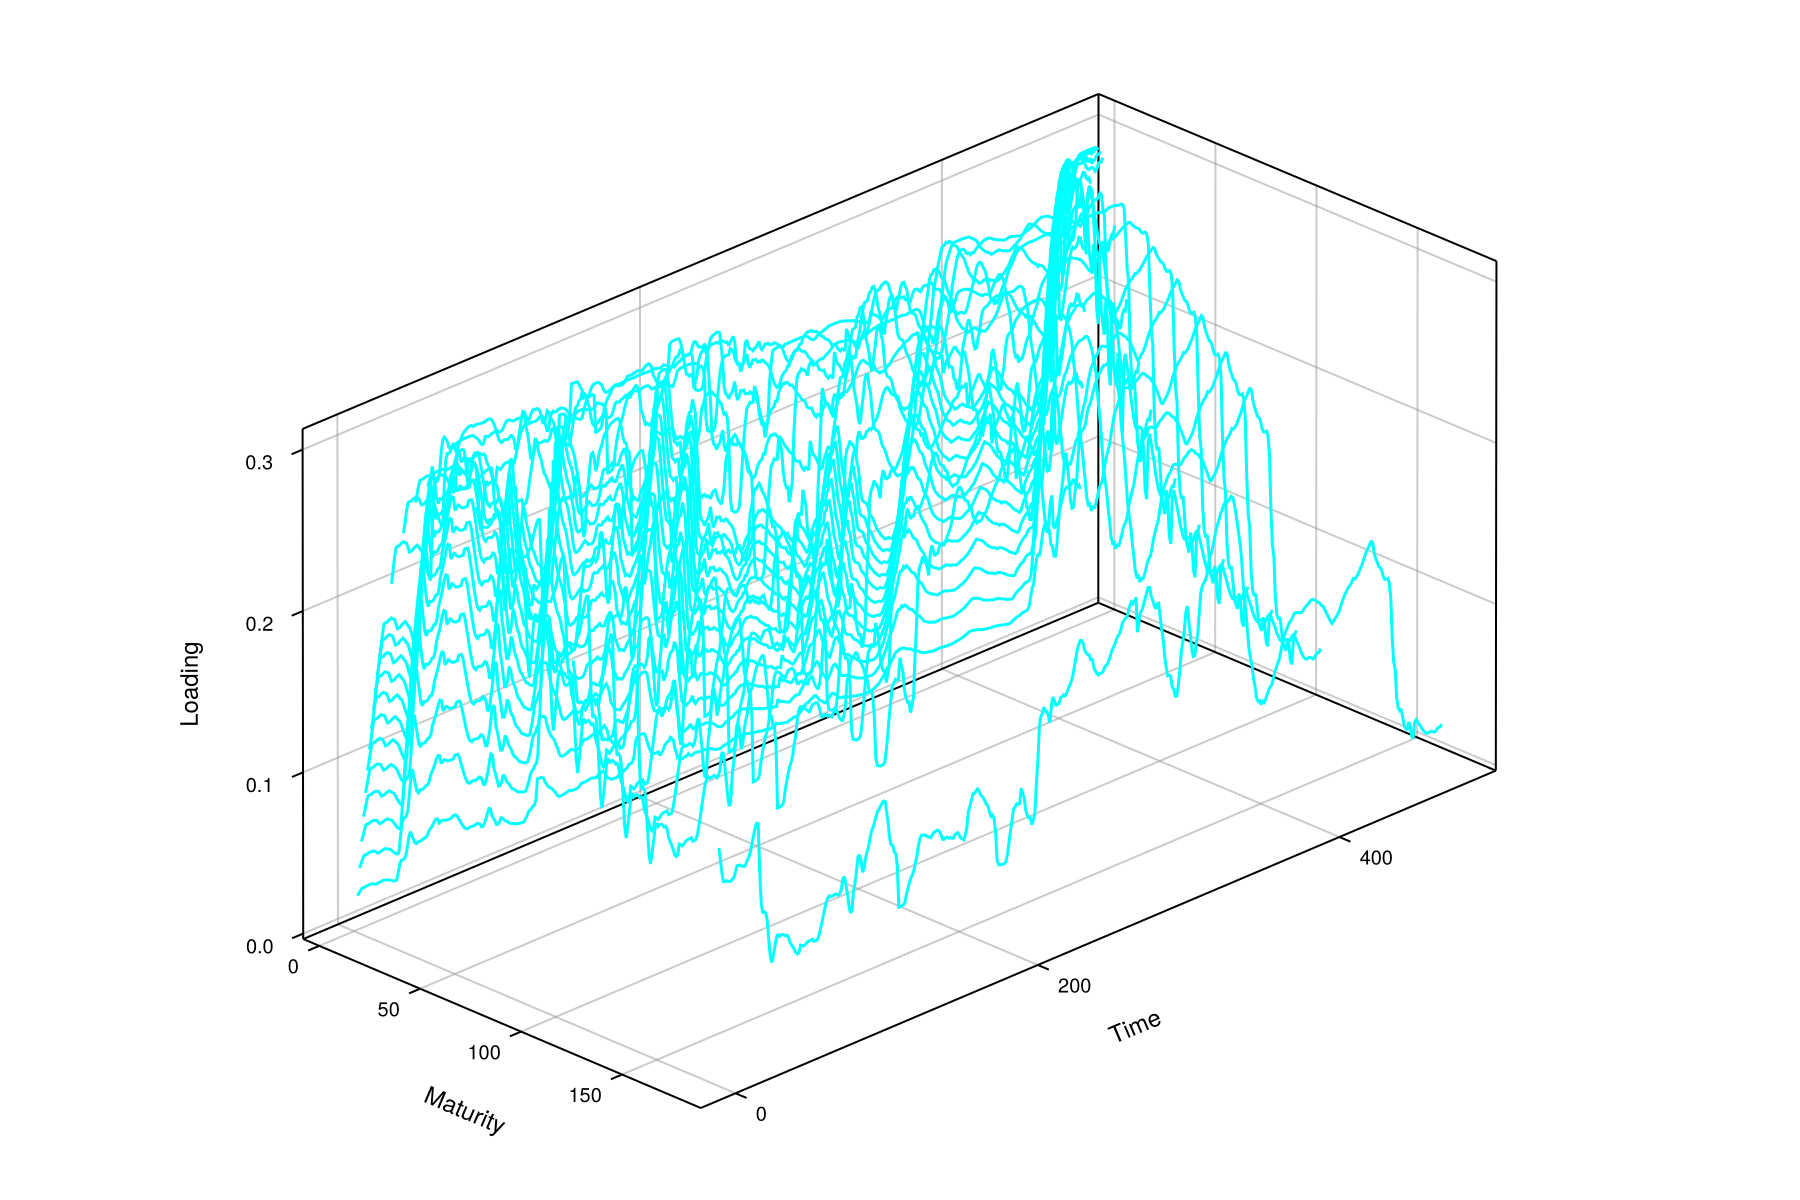

In [24]:


fac_path = "/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/$(model_name)/$(model_name)__thread_id__6__factor_loadings_2_filtered_outofsample.csv"
mat_path = "/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/data/thread_id__6__maturities.csv"

Z = readdlm(fac_path, ',', Float64)      # (T × M)
Y = vec(readdlm(mat_path, ',', Float64)) # (M)
T, M = size(Z)
t = 1:T

# --- Create wireframe ---
fig = Figure(resolution = (900, 600))
ax = Axis3(fig[1, 1];
    xlabel="Time",
    ylabel="Maturity",
    zlabel="Loading",
    aspect=(2.0, 1.0, 1.0),  # Make time axis 2× as long as Y-axis
    elevation=25 * π / 180,
    azimuth=45 * π / 180,
    xreversed=true,
    backgroundcolor=:gray20,
    xgridcolor=(:gray60, 0.5),
    ygridcolor=(:gray60, 0.5),
    zgridcolor=(:gray60, 0.5),
    xticklabelsize=10,
    yticklabelsize=10,
    zticklabelsize=10,
    xlabelsize=12,
    ylabelsize=12,
    zlabelsize=12,

)

# draw lines for each maturity
for m in 1:M
    lines!(ax, t, fill(Y[m], T), Z[:, m], color=:cyan)
end
fig

(480, 24)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/4JW9B/src/scenes.jl:264


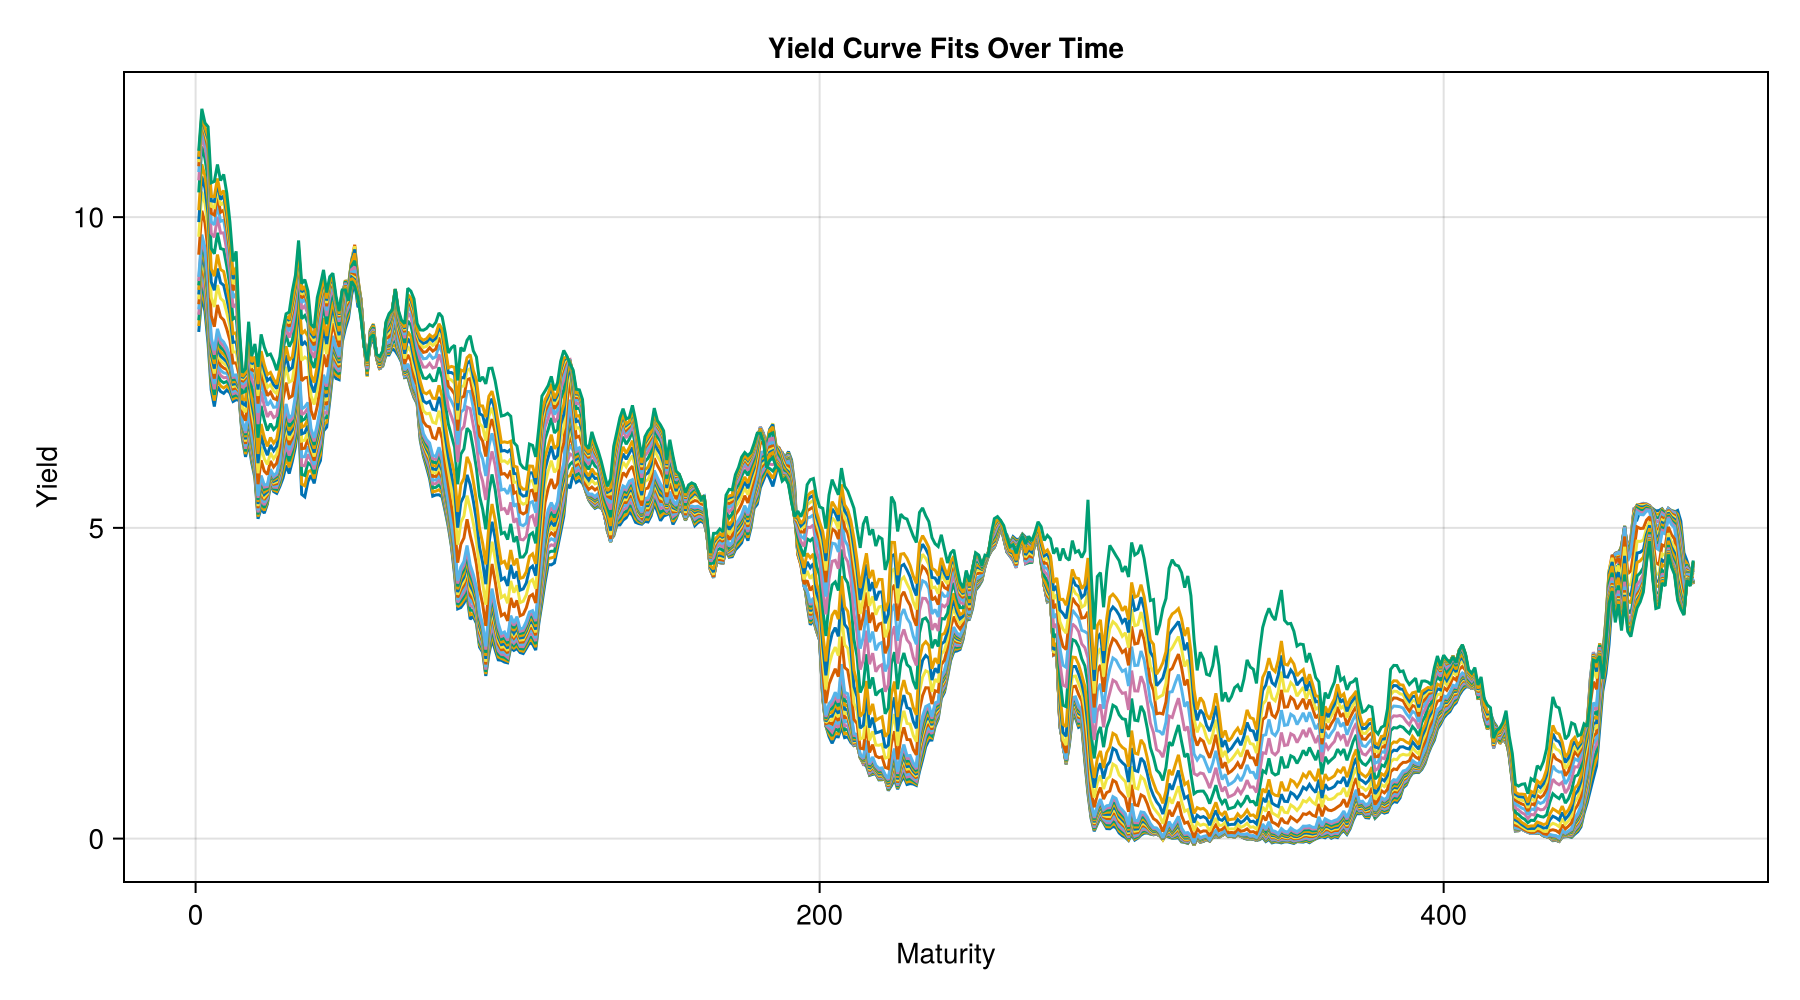

In [25]:
# plot predictions /Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/NS/NS__thread_id__6__fit_filtered_outofsample.csv
fit_data = readdlm("/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/$(model_name)/$(model_name)__thread_id__6__fit_filtered_outofsample.csv", ',')

# size is (480, 24)
println(size(fit_data))

# plot all 24 lines in one plot 
f2 = Figure(resolution = (900, 500))
ax2 = Axis(f2[1, 1], xlabel = "Maturity", ylabel = "Yield", title = "Yield Curve Fits Over Time")
for i in 1:size(fit_data, 2)
    lines!(ax2, 1:size(fit_data, 1), fit_data[:, i])
end
f2


## 5. Test `predict` Function

Test the full prediction over all time periods.

In [ ]:
# Test predict function
println("Testing predict function...")
println("This function should return:")
println("  - Factors (M × T matrix)")
println("  - States (L × T matrix)")
println("  - Predictions (N × T matrix)")
println("  All stacked vertically: (M+L+N) × T")

# Note: Call with your actual model
# results = predict(model, data)
# println("\nExpected output shape: ", (M+L+N, T))
# println("Actual output shape: ", size(results))

Testing predict function...
This function should return:
  - Factors (M × T matrix)
  - States (L × T matrix)
  - Predictions (N × T matrix)
  All stacked vertically: (M+L+N) × T


## 6. Visualization (Optional)

Visualize the predictions vs actual data.

In [ ]:
# Using Plots.jl for visualization
using Plots

# Plot actual yield data
plot(1:T, data[1, :], label="Yield 1 (actual)", 
     xlabel="Time", ylabel="Yield", 
     title="Yield Curve Data", linewidth=2)
plot!(1:T, data[3, :], label="Yield 3 (actual)", linewidth=2)
plot!(1:T, data[5, :], label="Yield 5 (actual)", linewidth=2)

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (8), incompatible header (4))

[83247] signal 2: Interrupt: 2
in expression starting at none:1
_ZNK12_GLOBAL__N_132AArch64PostLegalizerLoweringInfo7combineERN4llvm19GISelChangeObserverERNS1_12MachineInstrERNS1_16MachineIRBuilderE at /Users/siccokooiker/.julia/juliaup/julia-1.11.5+0.aarch64.apple.darwin14/lib/julia/libLLVM.dylib (unknown line)
unknown function (ip: 0x0)
Allocations: 58988166 (Pool: 58986408; Big: 1758); GC: 31


LoadError: Failed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to "/Users/siccokooiker/.julia/compiled/v1.11/Plots/jl_gdwTbC".

In [ ]:
# After running predict, you can plot predictions vs actuals
# pred_start = M + L + 1
# predictions = results[pred_start:end, :]

# plot(1:T, data[1, :], label="Actual Yield 1", linewidth=2)
# plot!(1:T, predictions[1, :], label="Predicted Yield 1", 
#       linestyle=:dash, linewidth=2)
# title!("Actual vs Predicted Yields")

## 7. Performance and Diagnostics

In [ ]:
# Calculate prediction errors
# residuals = data .- predictions
# mse_per_yield = mean(residuals.^2, dims=2)

# println("MSE per yield:")
# for i in 1:N
#     println("  Yield $i: ", mse_per_yield[i])
# end

In [ ]:
# Plot factor evolution
# factors = results[1:M, :]

# plot(1:T, factors[1, :], label="Factor 1 (Level)", linewidth=2)
# plot!(1:T, factors[2, :], label="Factor 2 (Slope)", linewidth=2)
# plot!(1:T, factors[3, :], label="Factor 3 (Curvature)", linewidth=2)
# title!("Factor Evolution Over Time")
# xlabel!("Time")
# ylabel!("Factor Value")

## 8. Summary

This notebook demonstrates testing of the filter functionality. To fully run it, you'll need to:

1. Ensure your model type implements `AbstractYieldFactorModel`
2. Create a concrete model instance with appropriate parameters
3. Uncomment and run the actual function calls
4. Verify that all functions work correctly with your model structure